In [10]:
from gaiaxpy import calibrate

query_input = "SELECT TOP 2 source_id FROM gaiadr3.gaia_source WHERE has_xp_continuous = 'True'"
calibrated_spectra, sampling = calibrate(query_input)
print(calibrated_spectra)

INFO: Query finished. [astroquery.utils.tap.core]
             source_id                                               flux  \                                                                                                            0/2 [00:00<?, ?spec/s]
0  6904937940173366016  [6.5025932456341604e-18, 5.069590457398529e-18...   
1  6904937974533136896  [3.6411397729072327e-19, 1.1618285169376781e-1...   

                                          flux_error  
0  [3.574936612958386e-18, 2.6184605425036696e-18...  
1  [2.8900400036482815e-18, 2.1205140650688182e-1...  


In [11]:
calibrated_spectra, sampling = calibrate(query_input, output_file='espectros_xp', output_format='csv', save_file=True)

INFO: Query finished. [astroquery.utils.tap.core]


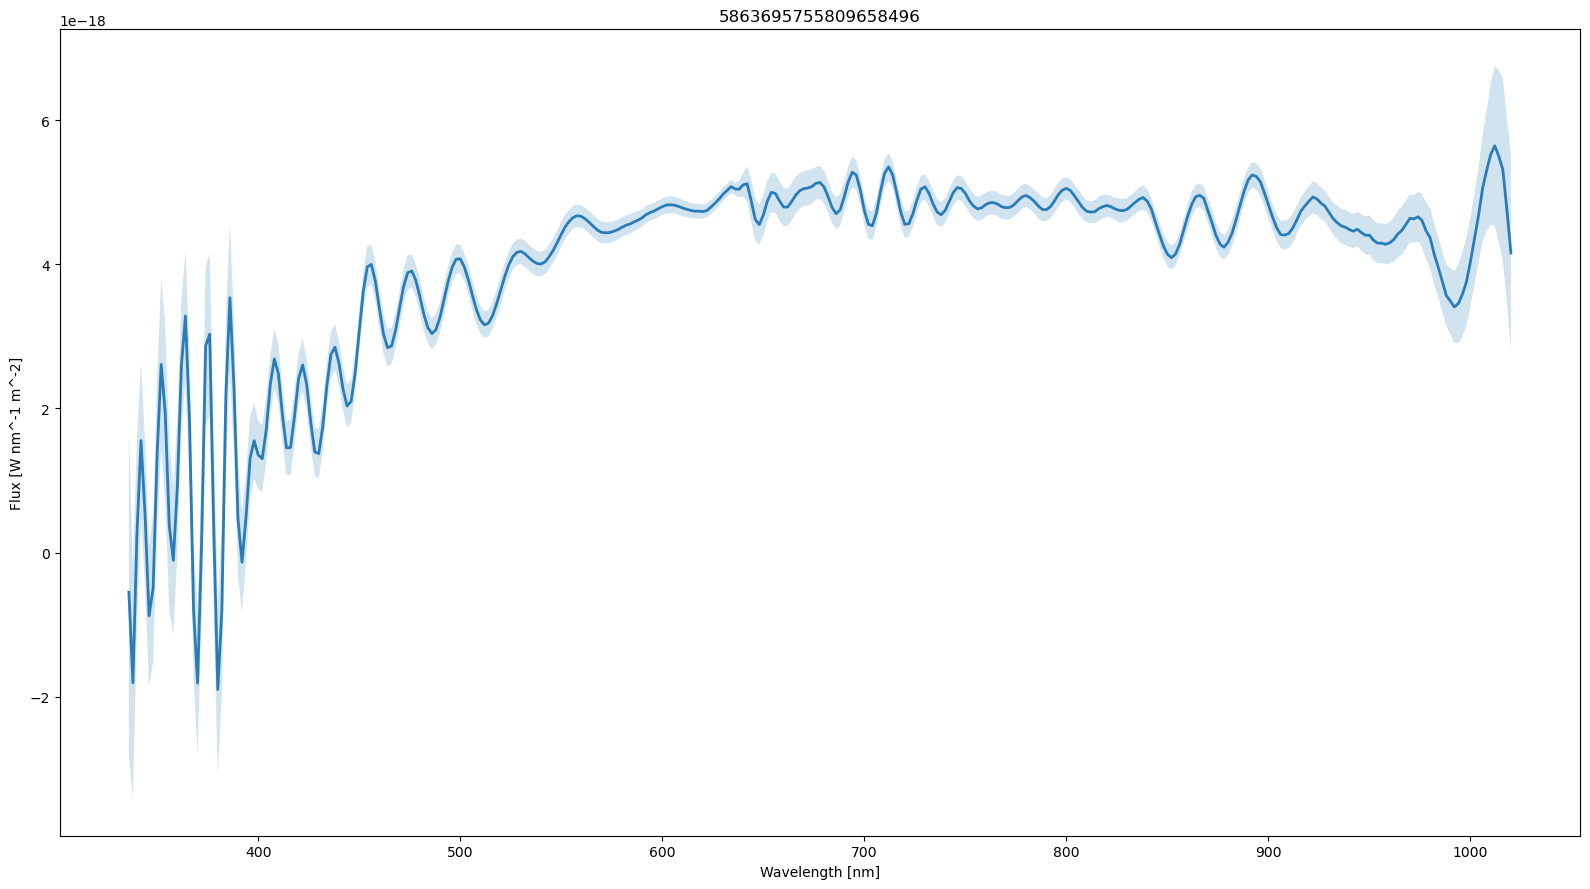

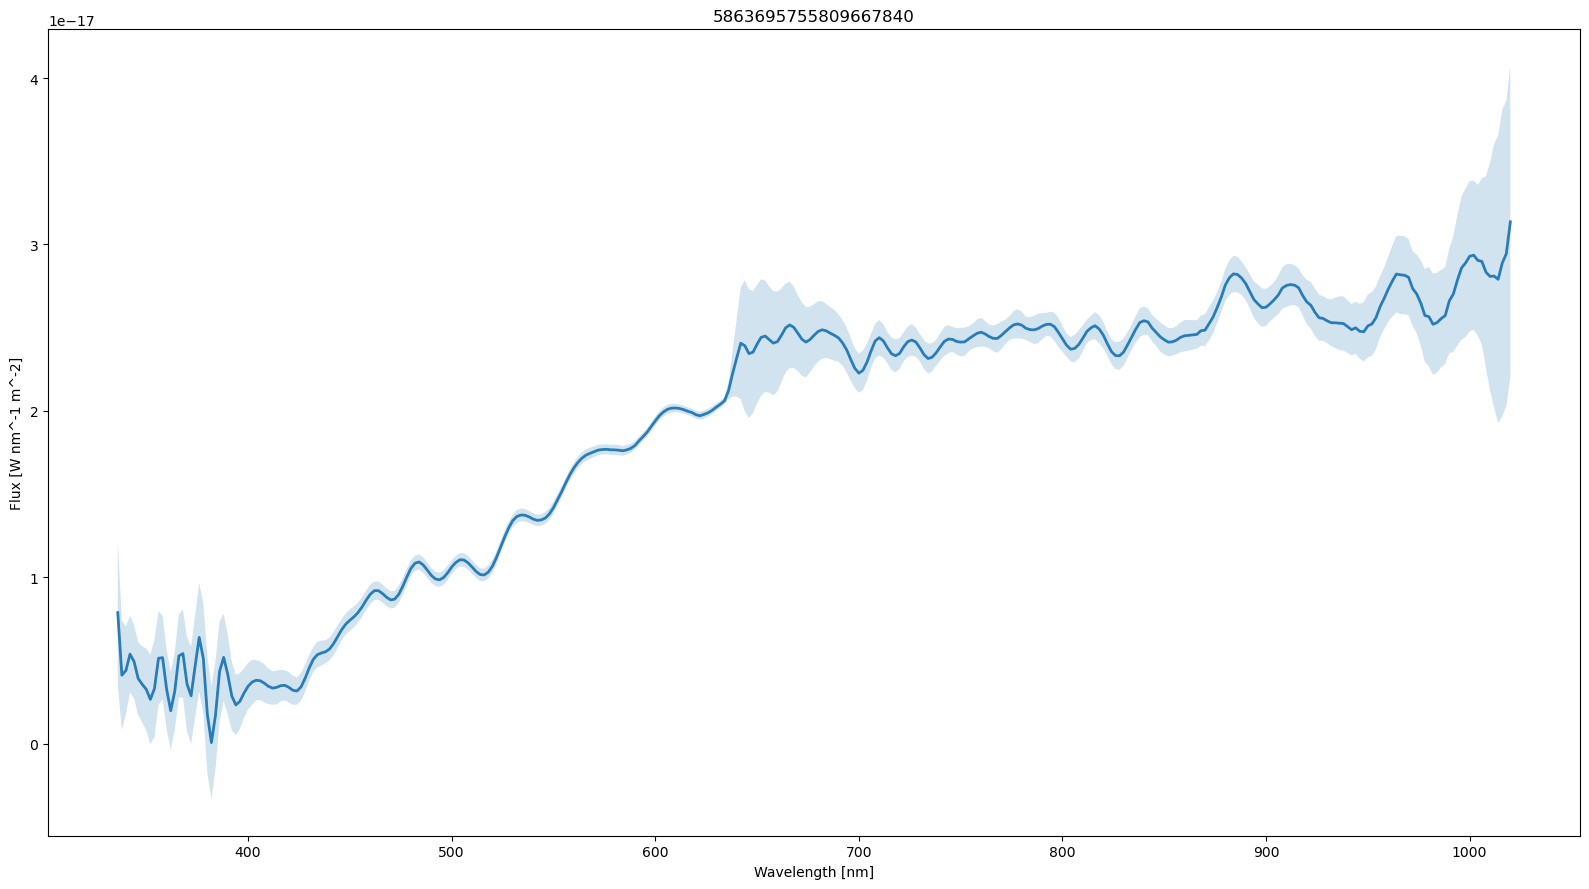

In [12]:
from gaiaxpy import plot_spectra

# Graficar todos los espectros en el DataFrame
plot_spectra(calibrated_spectra, sampling=sampling)

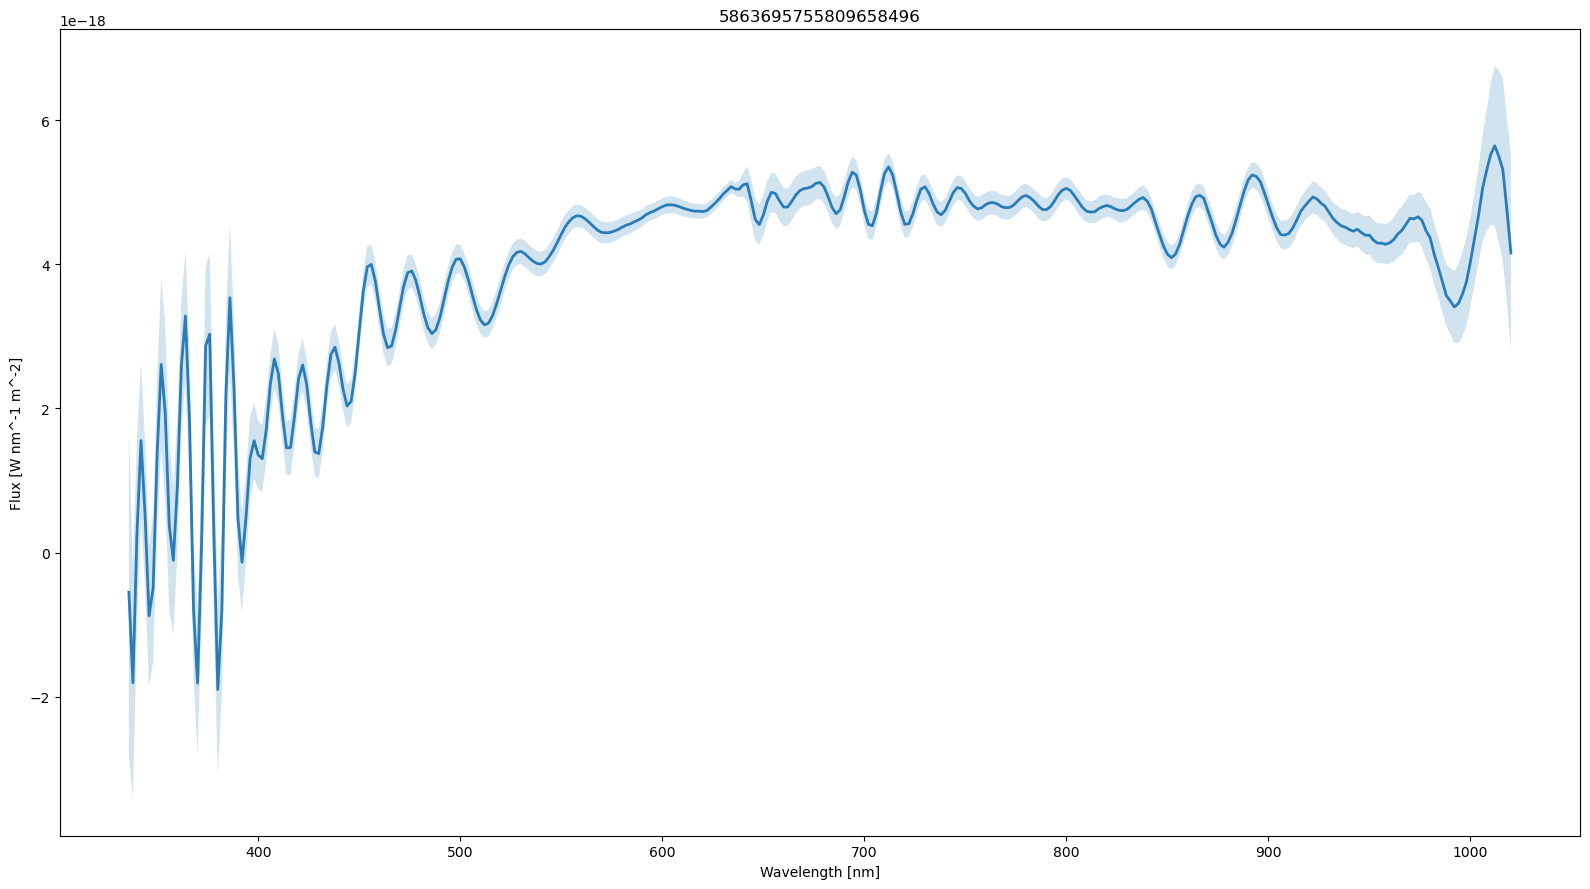

In [13]:
first_spectrum = calibrated_spectra.iloc[[0]]  # Selecciona la primera fila
plot_spectra(first_spectrum, sampling=sampling, legend=False)

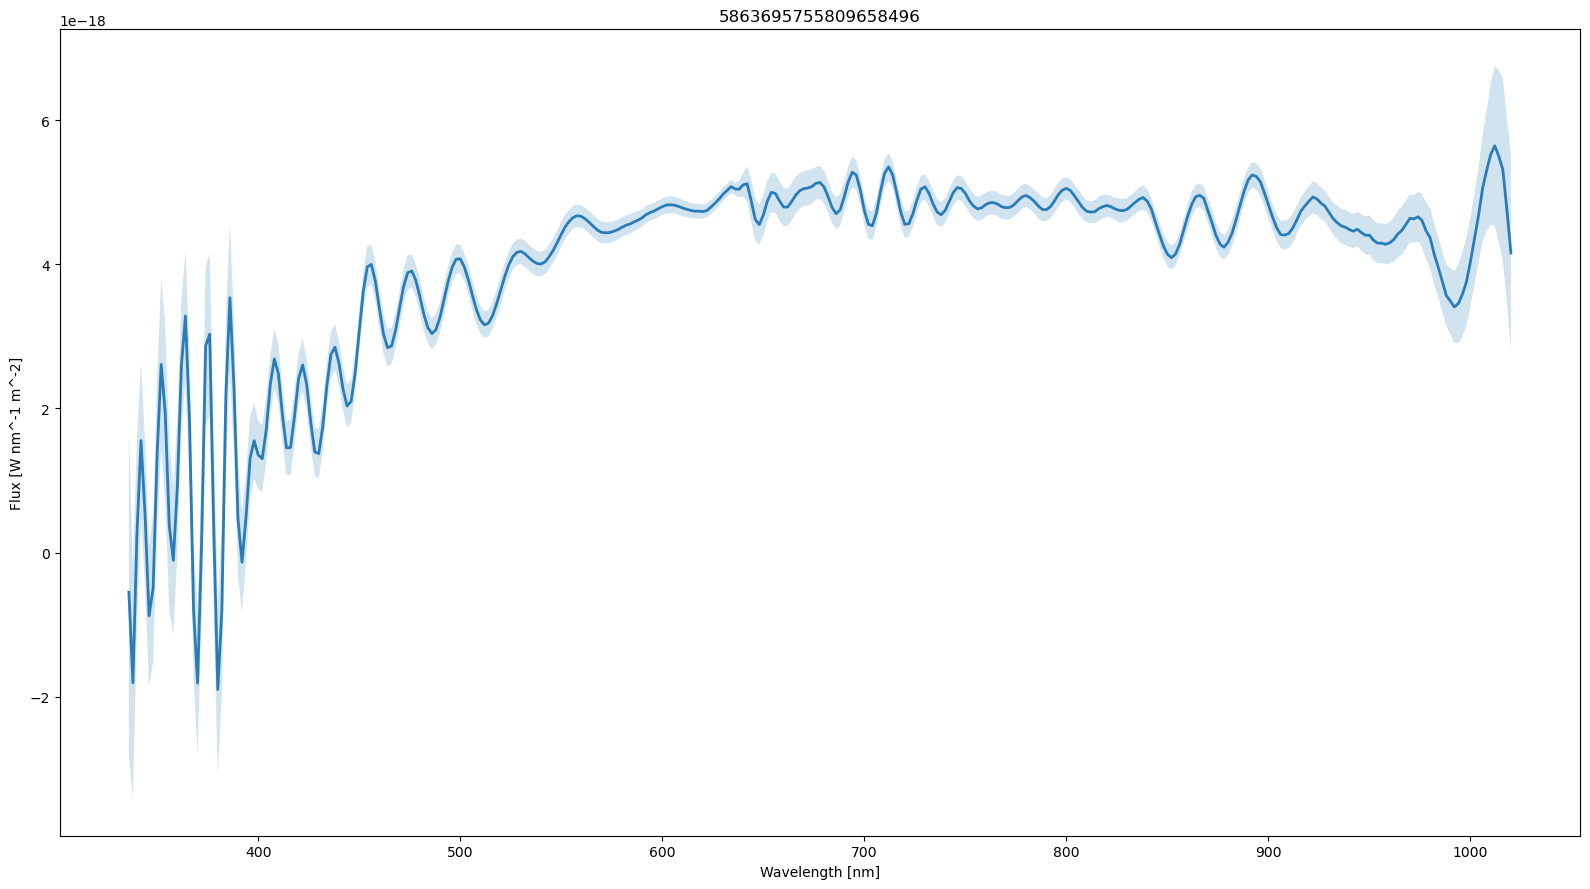

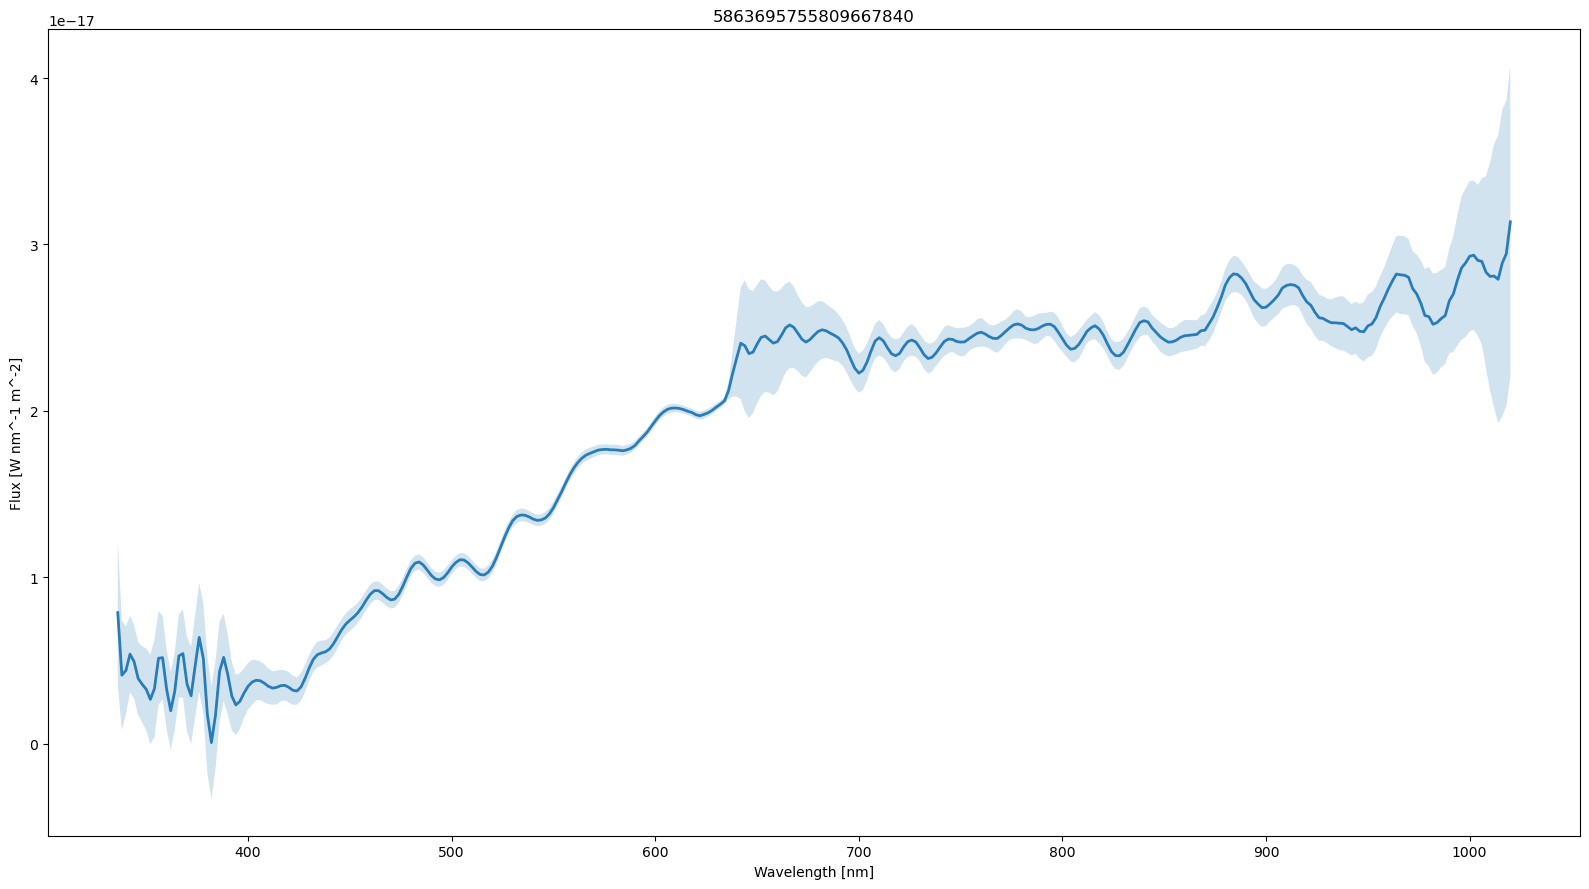

In [16]:
plot_spectra(calibrated_spectra, sampling=sampling, legend=True)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]                                                                                                                                       0/1 [00:00<?, ?spec/s]


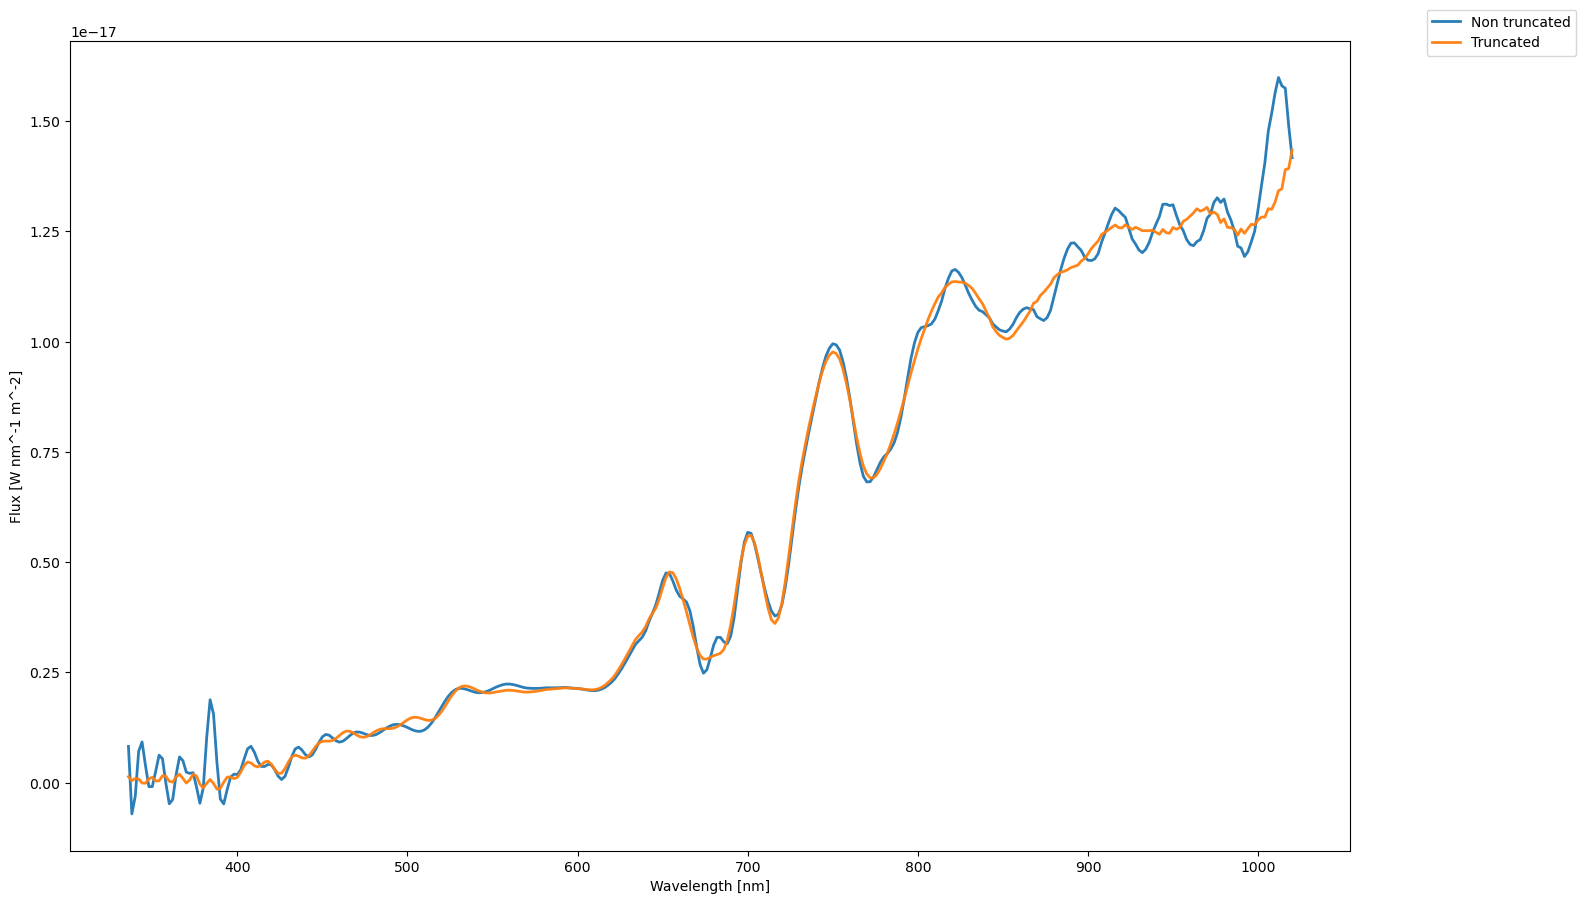

In [51]:
from gaiaxpy import calibrate, plot_spectra

# Consulta ADQL para 1 fuente
query_input = "SELECT TOP 1 source_id FROM gaiadr3.gaia_source WHERE has_xp_continuous = 'True'"

# Espectro NO truncado
non_truncated_spectra, sampling = calibrate(query_input)

# Espectro truncado
truncated_spectra, _ = calibrate(query_input, truncation=True)

# Combina ambos para plot
import pandas as pd
data = pd.concat([non_truncated_spectra, truncated_spectra]).reset_index(drop=True)
data['source_id'][0] = 'Non truncated'
data['source_id'][1] = 'Truncated'

plot_spectra(data, sampling=sampling, multi=True)

In [21]:
from gaiaxpy import generate, PhotometricSystem

# Suponiendo que tienes una consulta ADQL:
query_input = "SELECT TOP 2 source_id FROM gaiadr3.gaia_source WHERE has_xp_continuous = 'True'"

# Fotometría sintética JPLUS
synthetic_photometry = generate(query_input, photometric_system=PhotometricSystem.JPLUS)

print(synthetic_photometry)

INFO: Query finished. [astroquery.utils.tap.core]
             source_id  Jplus_mag_uJAVA  Jplus_mag_J0378  Jplus_mag_J0395  \                                                                                                            0/2 [00:00<?, ?spec/s]
0  5338638031083187584        14.240396        13.690384        13.124391   
1  5338638031083189888        18.706744        18.555856        18.217970   

   Jplus_mag_J0410  Jplus_mag_J0430  Jplus_mag_gJPLUS  Jplus_mag_J0515  \
0        12.953329        12.955247         12.877044        12.823874   
1        17.817641        17.692136         17.291855        17.090615   

   Jplus_mag_rJPLUS  Jplus_mag_J0660  ...  Jplus_flux_error_J0395  \
0         12.854113        12.959192  ...            1.656965e-30   
1         16.702430        16.640633  ...            1.793620e-31   

   Jplus_flux_error_J0410  Jplus_flux_error_J0430  Jplus_flux_error_gJPLUS  \
0            7.631639e-31            7.393399e-31             1.604597e-31   
1

In [22]:
# Acceder a la magnitud AB en el filtro J0378 para la primera fuente
mag_j0378 = synthetic_photometry.iloc[0]['Jplus_mag_J0378']

# Acceder al flujo sintético en el filtro J0378
flux_j0378 = synthetic_photometry.iloc[0]['Jplus_flux_J0378']

In [24]:
mag_j0378

13.690384101142534

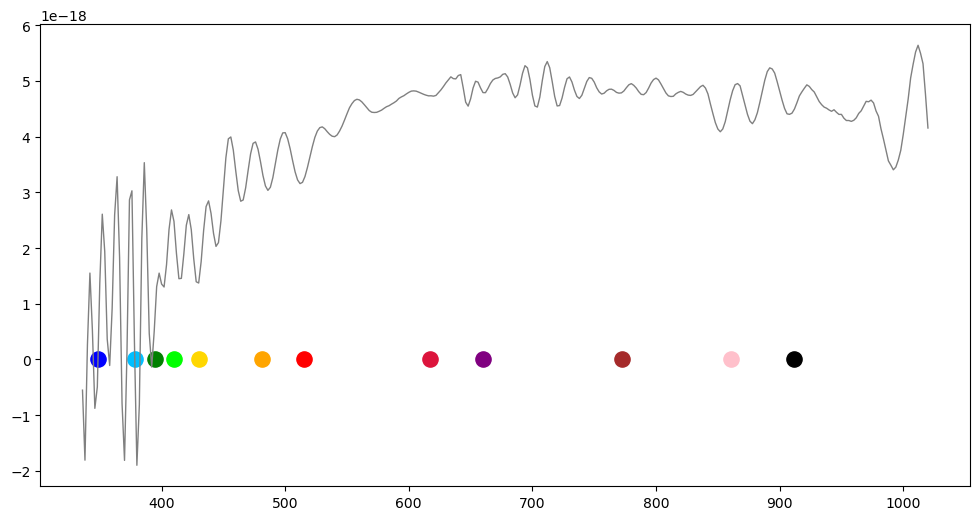

In [30]:
# 1. Arrays del espectro XP
sampling = np.array(sampling)  # Wavelength array (nm)
flux = np.array(calibrated_spectra.iloc[0]['flux'])  # XP flux array

plt.figure(figsize=(12,6))
plt.plot(sampling, flux, color='grey', lw=1, label='Gaia XP Spectrum')


scale_factor = synthetic_photometry.filter(like='Jplus_flux_').max().max()
for i, (filt, wav) in enumerate(filter_central_wavelengths.items()):
    colname = f'Jplus_flux_{filt}'
    if colname in synthetic_photometry.columns:
        flux_val = synthetic_photometry.iloc[0][colname] * scale_factor
        plt.scatter(wav, flux_val, color=colors[i], s=120, label=f'{filt} synthetic flux (scaled)')

In [44]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

In [52]:
# Define RA and DEC in degrees
ra_target = 302.187077
dec_target = 33.94195

# Create a SkyCoord object
coord = SkyCoord(ra=ra_target, dec=dec_target, unit=(u.degree, u.degree), frame='icrs')

# Define the search radius (e.g., 0.1 degrees)
radius = u.Quantity(0.1, u.deg)

In [53]:
# Perform a cone search to find Gaia sources
job = Gaia.cone_search_async(coordinate=coord, radius=radius)
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [55]:
# Filter for sources that have XP sampled spectra
sources_with_xp = r[r['has_xp_sampled'] == True]

if len(sources_with_xp) == 0:
    print("No sources with XP spectra found in the specified area.")
else:
    print(f"Found {len(sources_with_xp)} sources with XP spectra.")
    # You can now iterate through these sources and download their spectra
    # For example, to get the source_id of the first source:
    first_source_id = sources_with_xp['SOURCE_ID'][0]
    print(f"First source_id with XP spectra: {first_source_id}")

Found 1 sources with XP spectra.
First source_id with XP spectra: 2055320113770374912


             source_id                                               flux  \                                                                                                            0/1 [00:00<?, ?spec/s]
0  2055320113770374912  [3.475007056326357e-18, 3.2635815057350946e-18...   

                                          flux_error  
0  [4.0597949925098596e-18, 3.0240282745784733e-1...  


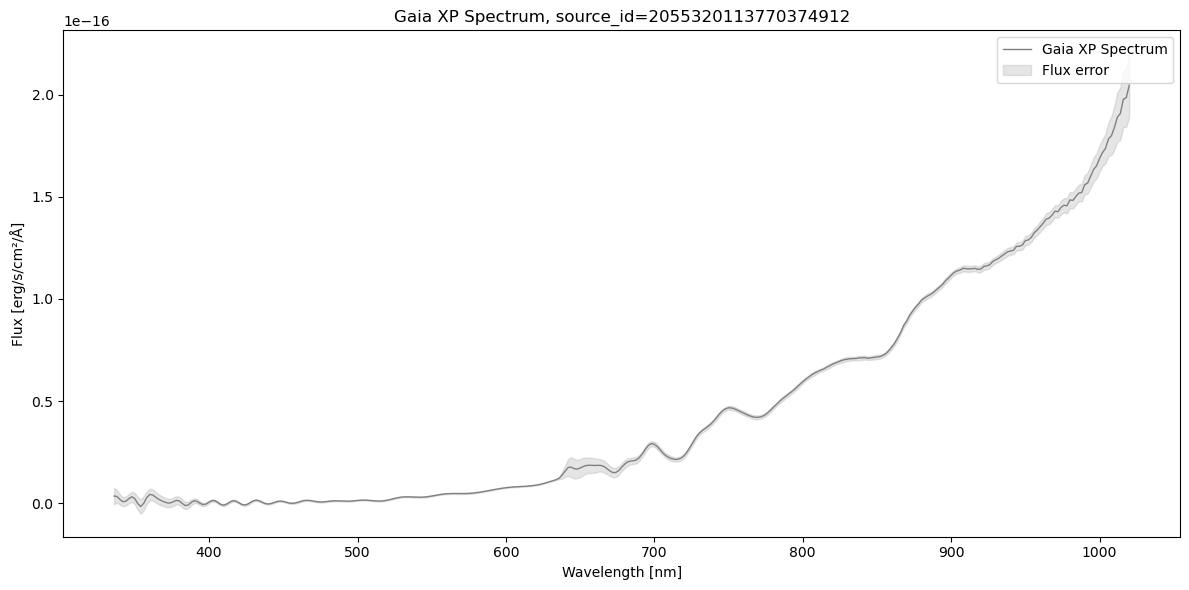

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from gaiaxpy import calibrate

source_id = 2055320113770374912
calibrated_spectra1 = calibrate([source_id])

# Si calibrate devuelve una tupla, extrae el DataFrame
if isinstance(calibrated_spectra1, tuple):
    calibrated_spectra1 = calibrated_spectra1[0]

print(calibrated_spectra1)

# Crea el eje de longitud de onda
sampling1 = np.arange(336, 1022, 2)  # nm

# Extrae el flujo
flux1 = calibrated_spectra1['flux'][0]
flux_error1 = calibrated_spectra1['flux_error'][0]

plt.figure(figsize=(12,6))
plt.plot(sampling1, flux, color='grey', lw=1, label='Gaia XP Spectrum')
plt.fill_between(sampling1, np.array(flux1)-np.array(flux_error1), np.array(flux1)+np.array(flux_error1), color='grey', alpha=0.2, label='Flux error')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Flux [erg/s/cm²/Å]')
plt.title(f'Gaia XP Spectrum, source_id={source_id}')
plt.legend()
plt.tight_layout()
plt.show()

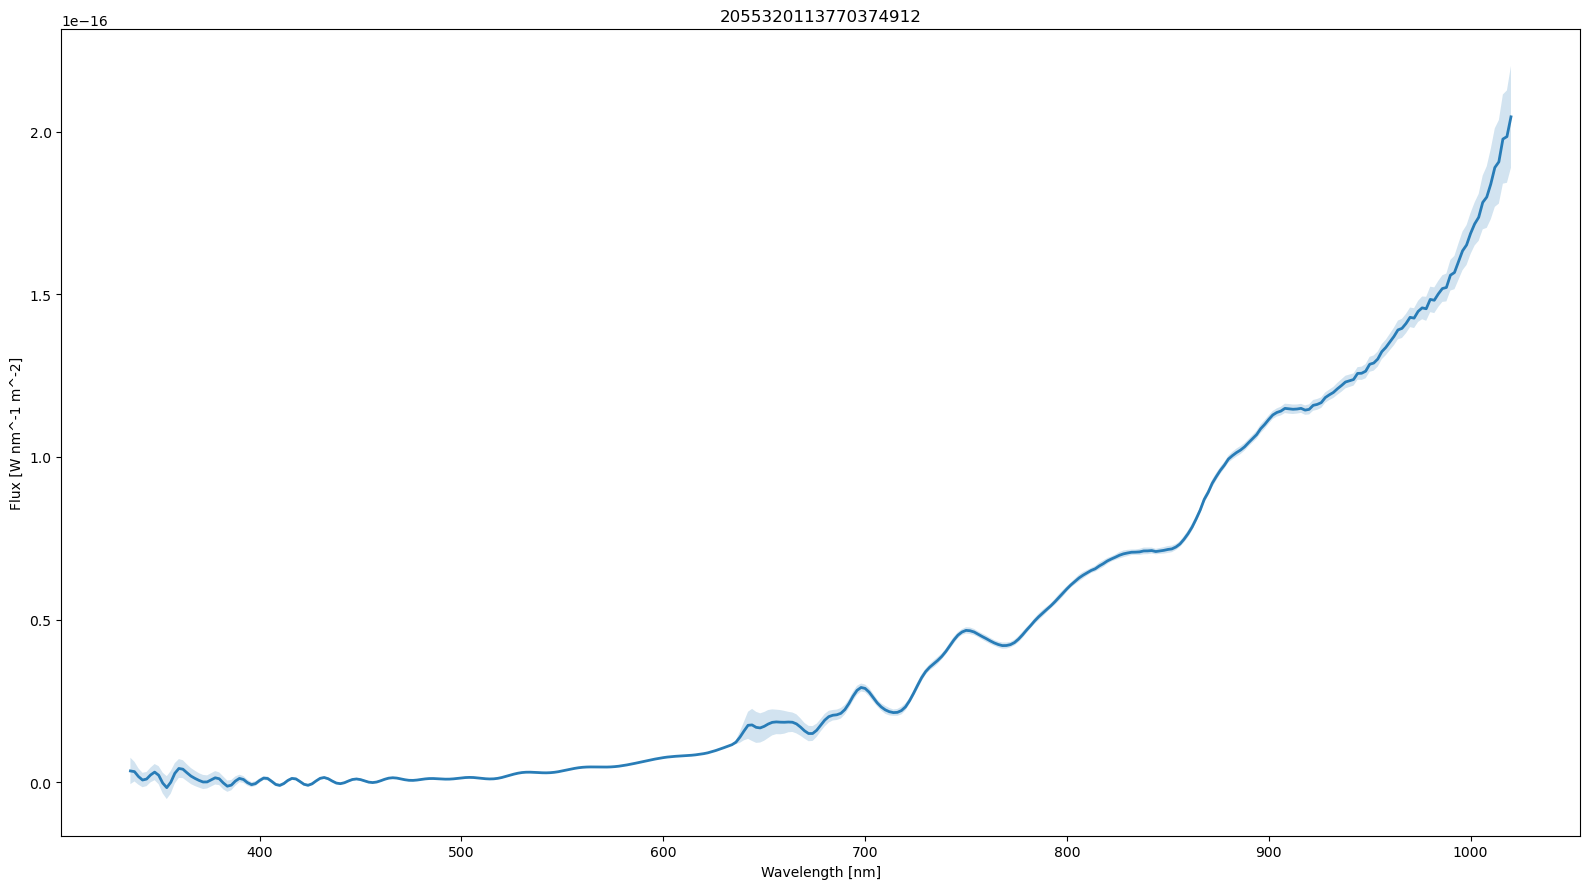

In [63]:
plot_spectra(calibrated_spectra1, sampling=sampling1)